In [ ]:
!nvidia-smi

Wed Jun  8 09:38:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and Unzip dataset from Google Drive

In [ ]:
!gdown --id 'YourGoogleDriveID' --output dataset.zip

!unzip "dataset.zip"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cXFJkWN__BddRvhCKaINpRWqxTCGd0IF
To: /content/dataset.zip
100% 417M/417M [00:05<00:00, 75.6MB/s]
Archive:  dataset.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml 

## Import Packages

In [ ]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

## Path Setup and Load Image

In [ ]:
annotation_folder = "/content/annotations"
image_folder = "/content/images"

file_list = os.listdir(image_folder)
print("All pictures are loaded! (Total: %s images in the dataset.)"%str(len(file_list)))

All pictures are loaded! (Total: 853 images in the dataset.)


### Function

In [ ]:
def read_annot(file_name, folder):

    save_box = []
    labels = []
    
    annotaion_file = os.path.join(folder, file_name[:-3]+'xml')
    element_tree = ET.parse(annotaion_file)
    
    
    for element in element_tree.iter():
        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text
                    if name == 'with_mask':
                        label_index = 1
                    elif name == 'mask_weared_incorrect':
                        label_index = 2
                    elif name == 'without_mask':
                        label_index = 3
                    
                    labels.append(label_index)
                    
                if 'bndbox' in attribute.tag:
                    xmin, ymin, xmax, ymax = 0, 0, 0, 0

                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                    
                    save_box.append([xmin,ymin,xmax,ymax])

    return save_box, labels

In [ ]:
def draw(image, box_position, labels):

    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box,label in zip(box_position,labels):
        box = [int(x) for x in box]
        if label == 1:
            color = (0, 225, 0) # green
            text = "Correct Mask"
        if label == 2:
            color = (0, 165, 255) # yellow
            text = "Incorrect Mask"
        elif label == 3:
            color = (0,0,225) # red
            text = "No Mask"
        
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,1)
        cv2.putText(img, text, (box[0],box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)
        
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#### This part is just for testing function works!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


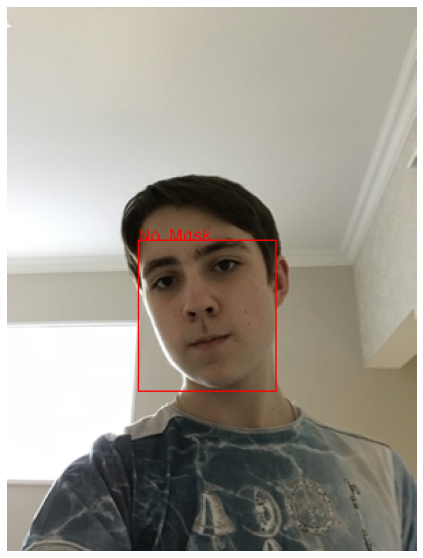

In [ ]:
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image

# Get the bbox and label
bbox, labels  = read_annot(image_name, annotation_folder)

#draw bounding boxes on the image
img = draw(plt.imread(os.path.join(image_folder,image_name)), bbox, labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

## Dataset Creation

In [ ]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

* Split training/validation/testing dataset

In [ ]:
from sklearn.model_selection import train_test_split
# Split training and testing dataset
training_dataset, testing_dataset = train_test_split(file_list, test_size=0.2, random_state=10)

print("Amount of images (Training/Testing): " + str(len(training_dataset)) +"/"+ str(len(testing_dataset)))

Amount of images (Training/Testing): 682/171


* Generate Dataset

In [ ]:
mask_dataset = image_dataset(training_dataset, image_folder, annotation_folder)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
print("Data Loaded!!")

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using 'cuda'")
else:
    device = torch.device('cpu')
    print("Using 'cpu'")

Data Loaded!!
Using 'cuda'


## Model Creation

In [ ]:
num_classes = 4 # background, without_mask, with_mask, incorrect_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)

num_epochs=50
print("Model Creation complete!!\nSetting epochs:", num_epochs)

## Training

* Unblock this part if continue training model

In [ ]:
'''
model.load_state_dict(torch.load("/content/weights.pth"))
print("Load Model Complete")
num_epochs = 15
print(num_epochs)
'''

'\nmodel.load_state_dict(torch.load("/content/weights.pth"))\nprint("Load Model Complete")\nnum_epochs = 15\nprint(num_epochs)\n'

In [ ]:
# Main training function
loss_list = []
best_weight_loss = 1000

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))

    if epoch_loss < best_weight_loss:
      best_weight_loss = epoch_loss
      torch.save(model.state_dict(),'/content/weights.pth')
      print("Saving Best Model ... (Epoch: %s)"%str(epoch+1))


Starting training....1/50
Epoch loss: 0.429 , time used: (244.2s)
Saving Best Model ... (Epoch: 1)
Starting training....2/50
Epoch loss: 0.302 , time used: (244.1s)
Saving Best Model ... (Epoch: 2)
Starting training....3/50
Epoch loss: 0.252 , time used: (241.6s)
Saving Best Model ... (Epoch: 3)
Starting training....4/50
Epoch loss: 0.248 , time used: (243.9s)
Saving Best Model ... (Epoch: 4)
Starting training....5/50
Epoch loss: 0.232 , time used: (242.8s)
Saving Best Model ... (Epoch: 5)
Starting training....6/50
Epoch loss: 0.195 , time used: (243.4s)
Saving Best Model ... (Epoch: 6)
Starting training....7/50
Epoch loss: 0.176 , time used: (245.1s)
Saving Best Model ... (Epoch: 7)
Starting training....8/50
Epoch loss: 0.165 , time used: (242.5s)
Saving Best Model ... (Epoch: 8)
Starting training....9/50
Epoch loss: 0.154 , time used: (244.1s)
Saving Best Model ... (Epoch: 9)
Starting training....10/50
Epoch loss: 0.145 , time used: (240.6s)
Saving Best Model ... (Epoch: 10)
Starting

## Predict

In [ ]:
def img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

In [ ]:
def visualize_predict(file, save=False):
    image_path = os.path.join(image_folder,file)
    annot_path = os.path.join(annotation_folder,file)
    test_img = Image.open(image_path).convert('RGB')
    
    # Prediction
    test_img, test_boxes, test_labels = img_predict(test_img)
    test_output = draw(test_img, test_boxes,test_labels)

    # Draw the bounding box of ground truth
    bbox, labels  = read_annot(annot_path, annotation_folder)
    #draw bounding boxes on the image
    gt_output = draw(test_img, bbox,labels)

    # Display the result
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.imshow(test_output)
    ax1.set_xlabel('Prediction')
    ax2.imshow(gt_output)
    ax2.set_xlabel('Ground Truth')
    plt.show()

    if save:
        directory = "/content/output"
        os.chdir(directory)
        file_name = file + "_predict_gt.png"
        cv2.imwrite(file_name, gt_output)
        file_name = file + "_predict.png"
        cv2.imwrite(file_name, test_output)

    return

* Show predict result

In [ ]:
total_file_count = len(testing_dataset)
os.chdir("/content")
#os.mkdir("output")

'''
for idx in range(total_file_count):
    visualize_predict(testing_dataset[idx], save=True)
'''
for idx in range(total_file_count):
    visualize_predict(testing_dataset[idx], save=False)



## Save Model

In [ ]:

from google.colab import files
files.download("/content/weights.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Save output folder

In [ ]:
'''
!zip -r /content/output.zip /content/output2

from google.colab import files
files.download("/content/output.zip")
'''

'\n!zip -r /content/output.zip /content/output2\n\nfrom google.colab import files\nfiles.download("/content/output.zip")\n'